<a href="https://colab.research.google.com/github/Cinnameldehyde/Raspberry-Pi/blob/main/Model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Required Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import os
Root = "/content/drive/MyDrive/archive-4"
os.chdir(Root)

In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)



from matplotlib import style
style.use('fivethirtyeight')

In [4]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image
from glob import glob
from google.colab import drive

In [5]:
for dirname, _, filenames in os.walk('/content/gdrive/My Drive/archive-4/Test/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Assigning Path for Dataset

In [6]:
data_dir = "/content/drive/MyDrive/archive-4"
train_path = 'Train'
test_path = 'Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes

In [7]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [8]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

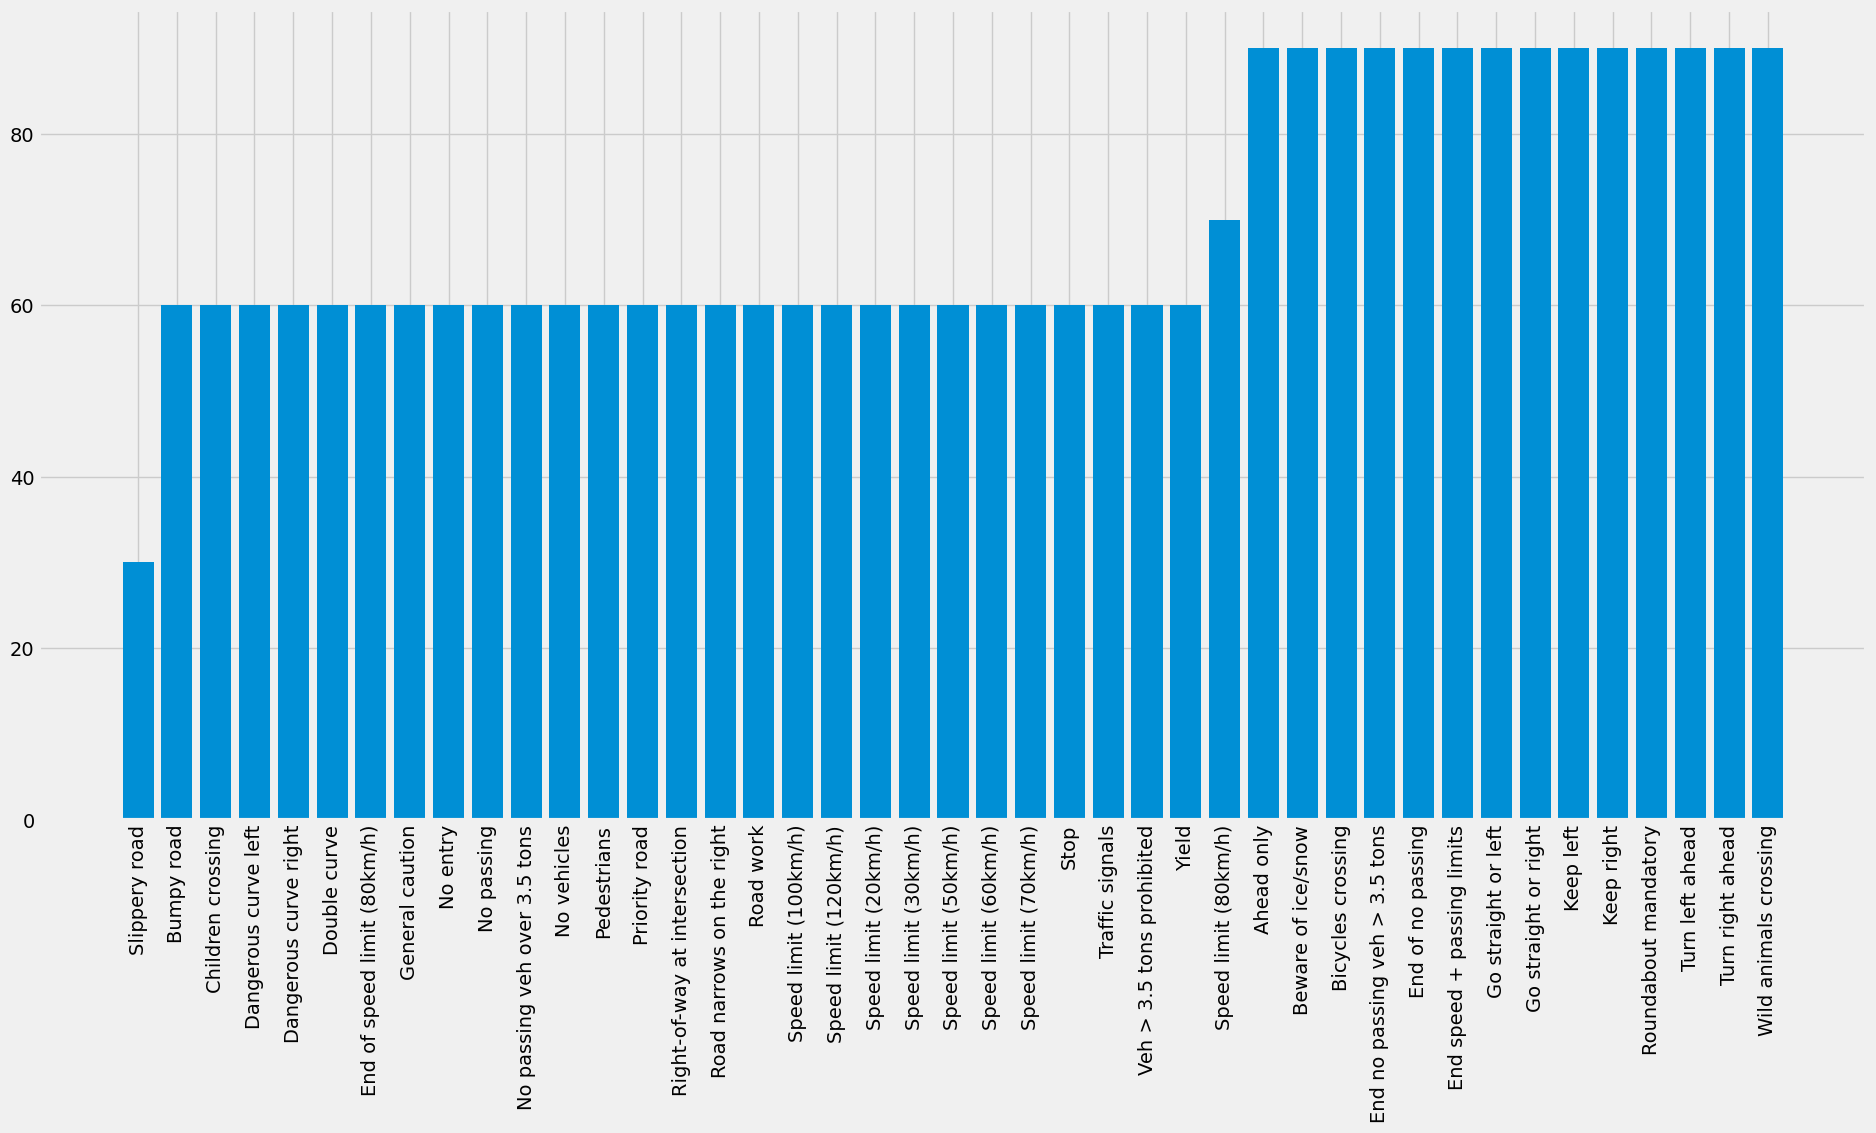

In [9]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

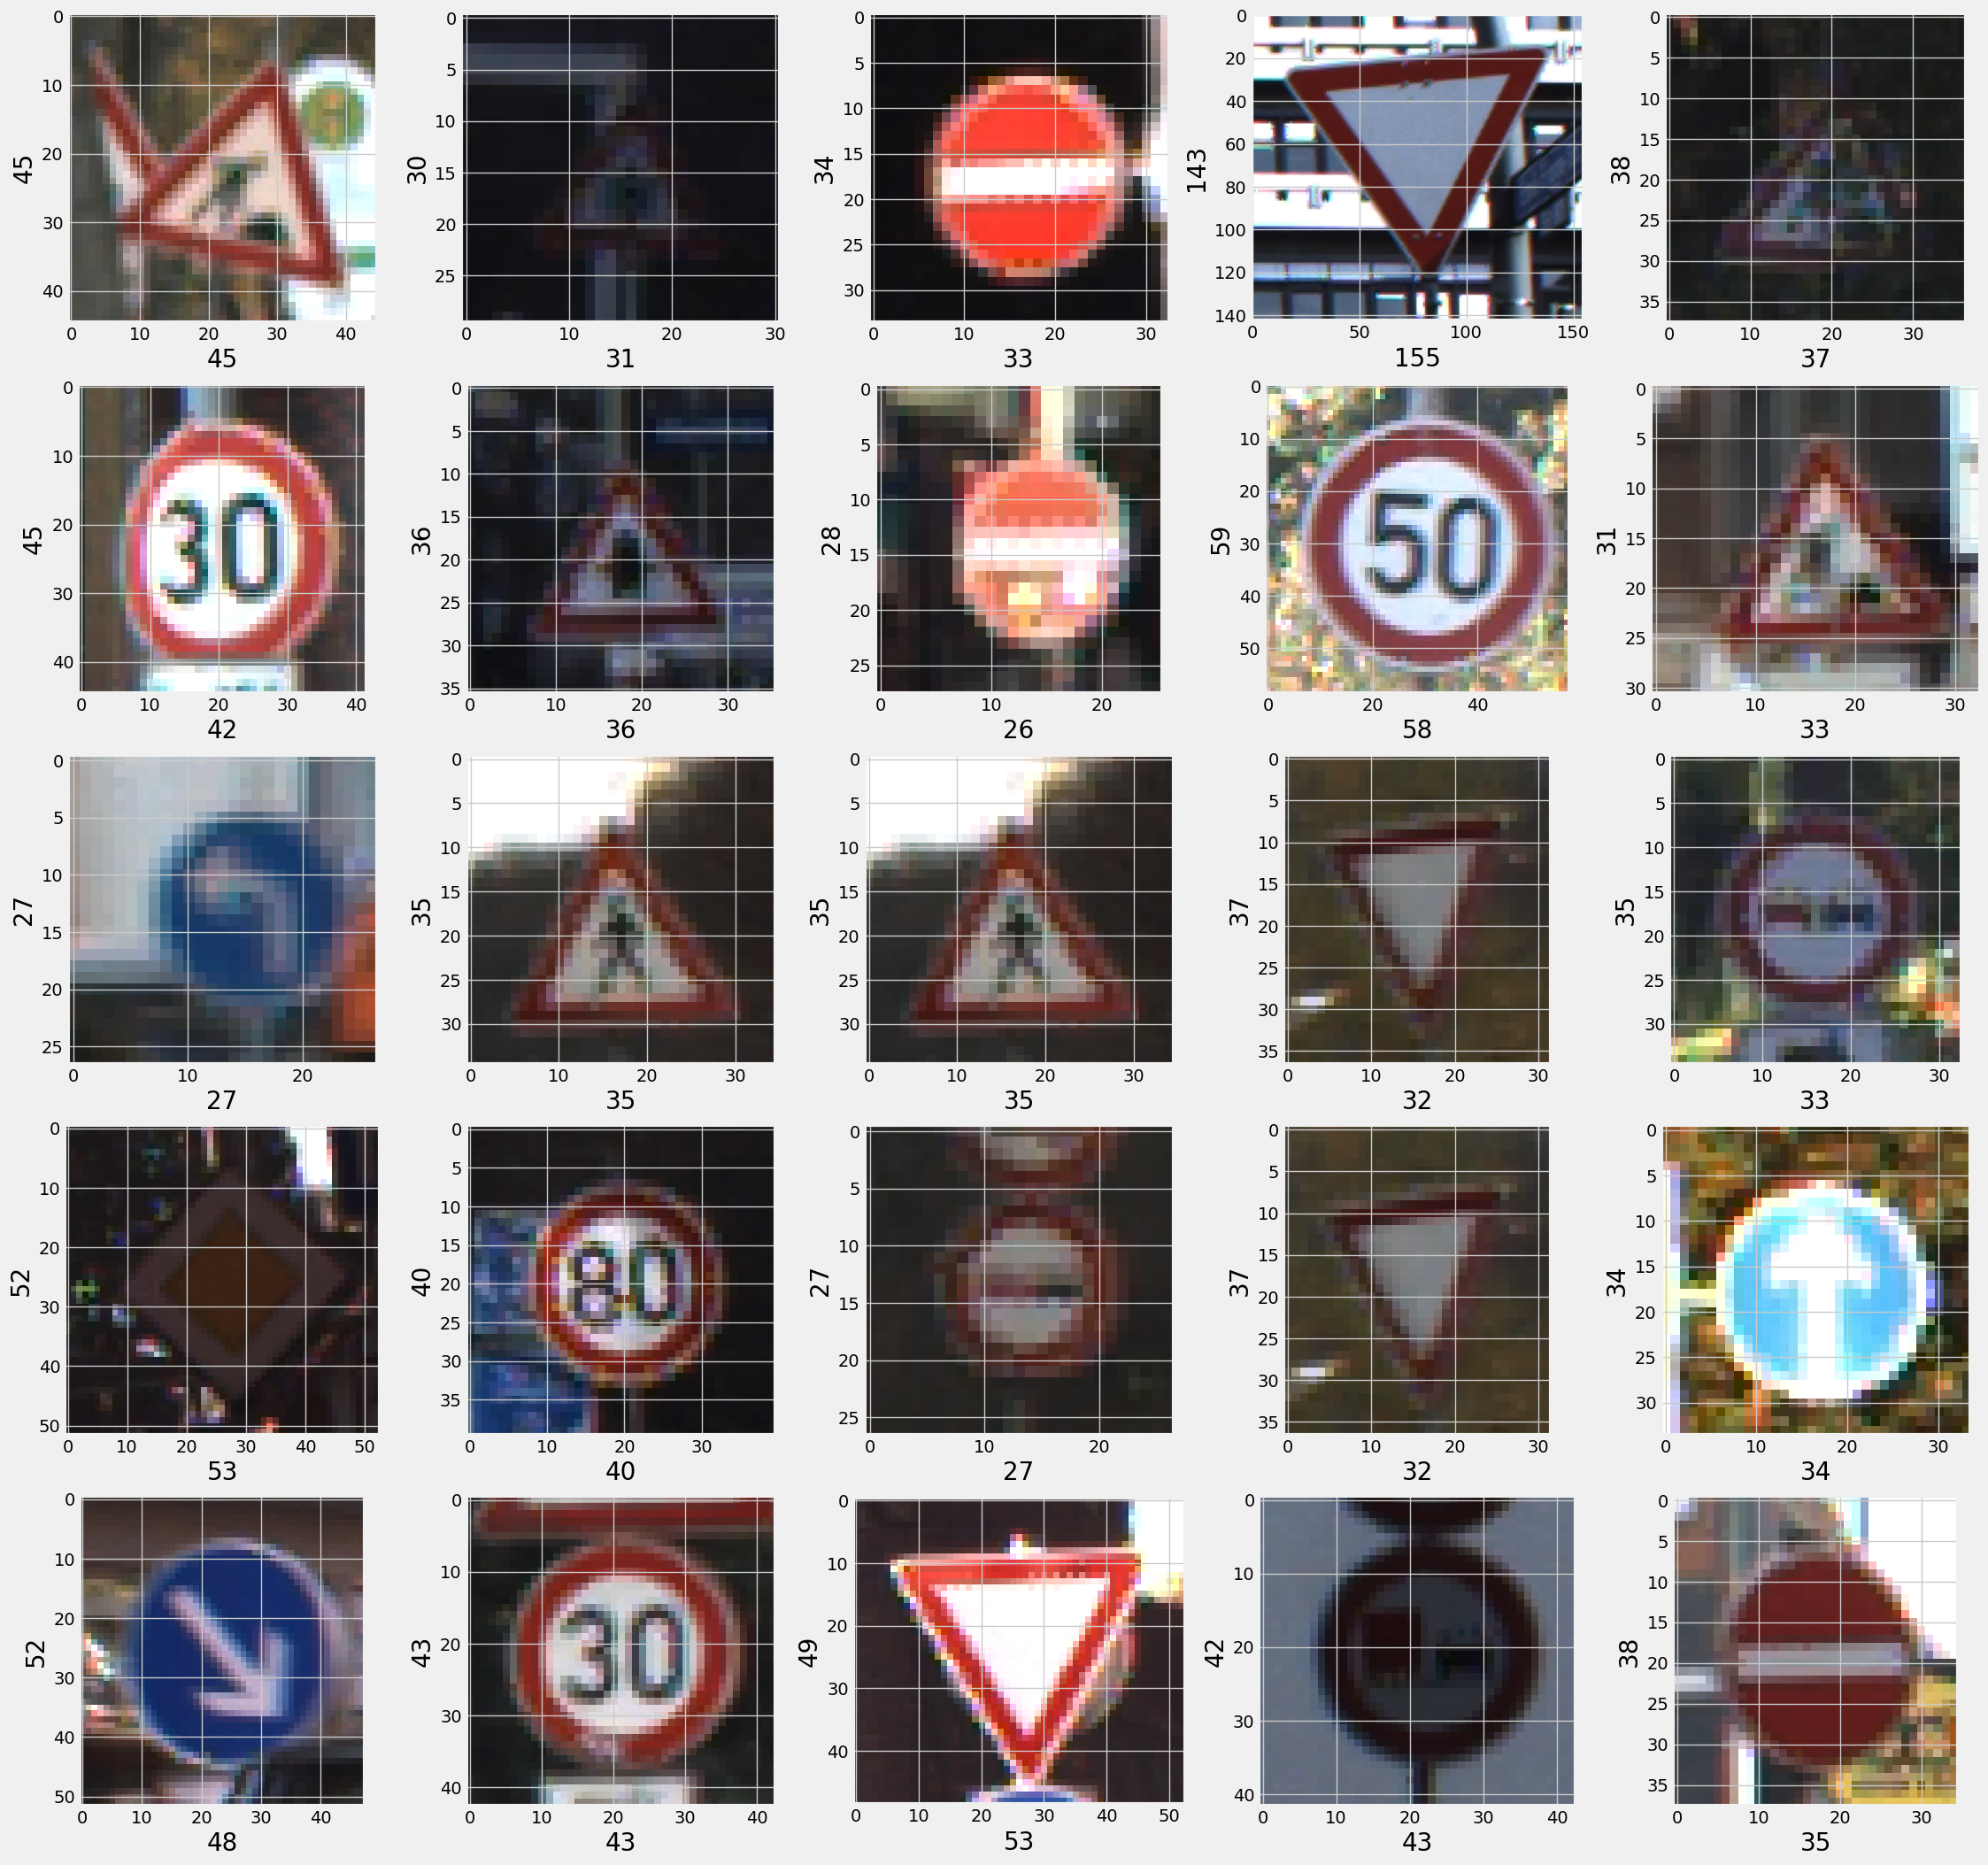

In [10]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread
import pandas as pd # Make sure pandas is imported
import matplotlib.pyplot as plt

test = pd.read_csv(data_dir + '/Test.csv')


imgs = test["Path"].values


plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    #plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data

In [11]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(2980, 30, 30, 3) (2980,)


## Shuffling the training data

In [12]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [13]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (2086, 30, 30, 3)
X_valid.shape (894, 30, 30, 3)
y_train.shape (2086,)
y_valid.shape (894,)


## One hot encoding the labels

In [14]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(2086, 43)
(894, 43)


## Making the model

In [15]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
lr = 0.001
epochs = 50

#opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=lr,
    decay_rate=lr / (epochs * 0.5))
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Augmenting the data and training the model

In [31]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=50), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.9839 - loss: 0.0480 - val_accuracy: 0.9888 - val_loss: 0.0310
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.9855 - loss: 0.0534 - val_accuracy: 0.9944 - val_loss: 0.0147
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.9925 - loss: 0.0338 - val_accuracy: 0.9966 - val_loss: 0.0110
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.9880 - loss: 0.0557 - val_accuracy: 0.9966 - val_loss: 0.0097
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 0.9863 - loss: 0.0511 - val_accuracy: 0.9978 - val_loss: 0.0093
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.9753 - loss: 0.0754 - val_accuracy: 0.9978 - val_loss: 0.0092
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - accuracy: 0.9789 - loss: 0.0684 - val_accuracy: 0.9978 - val_loss: 0.0092
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - accuracy: 0.9828 - loss: 0.0451 - val_accuracy: 0.9978 -

In [32]:
#model.save("model.h5")
model.save('model.keras')

In [33]:
model.save_weights("/content/drive/MyDrive/archive-4/output.weights.h5")

In [34]:
dir(aug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_api_export_path',
 '_api_export_symbol_id',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standardize',
 'std',
 'verti

## Evaluating the model

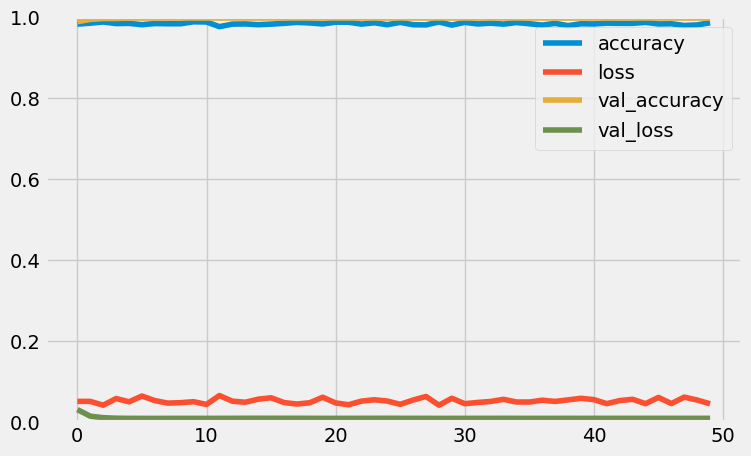

In [35]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions

In [36]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred=model.predict(X_test).round()
pred = np.argmax(pred, axis=1)
#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Test Data accuracy:  40.83769633507853


## Visualizing the confusion matrix

In [37]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

In [38]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

ValueError: Shape of passed values is (41, 41), indices imply (43, 43)

## Classification report

In [39]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         8
           3       0.50      0.89      0.64         9
           4       0.00      0.00      0.00         9
           5       1.00      0.20      0.33         5
           6       0.50      0.50      0.50         2
           7       0.00      0.00      0.00         8
           8       0.20      0.33      0.25         6
           9       1.00      0.40      0.57        10
          10       0.67      0.55      0.60        11
          11       0.50      0.12      0.20         8
          12       1.00      0.29      0.44         7
          13       1.00      0.50      0.67        10
          14       0.43      1.00      0.60         3
          15       0.50      0.50      0.50         2
          16       1.00      1.00      1.00         4
          17       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

## Predictions on Test Data

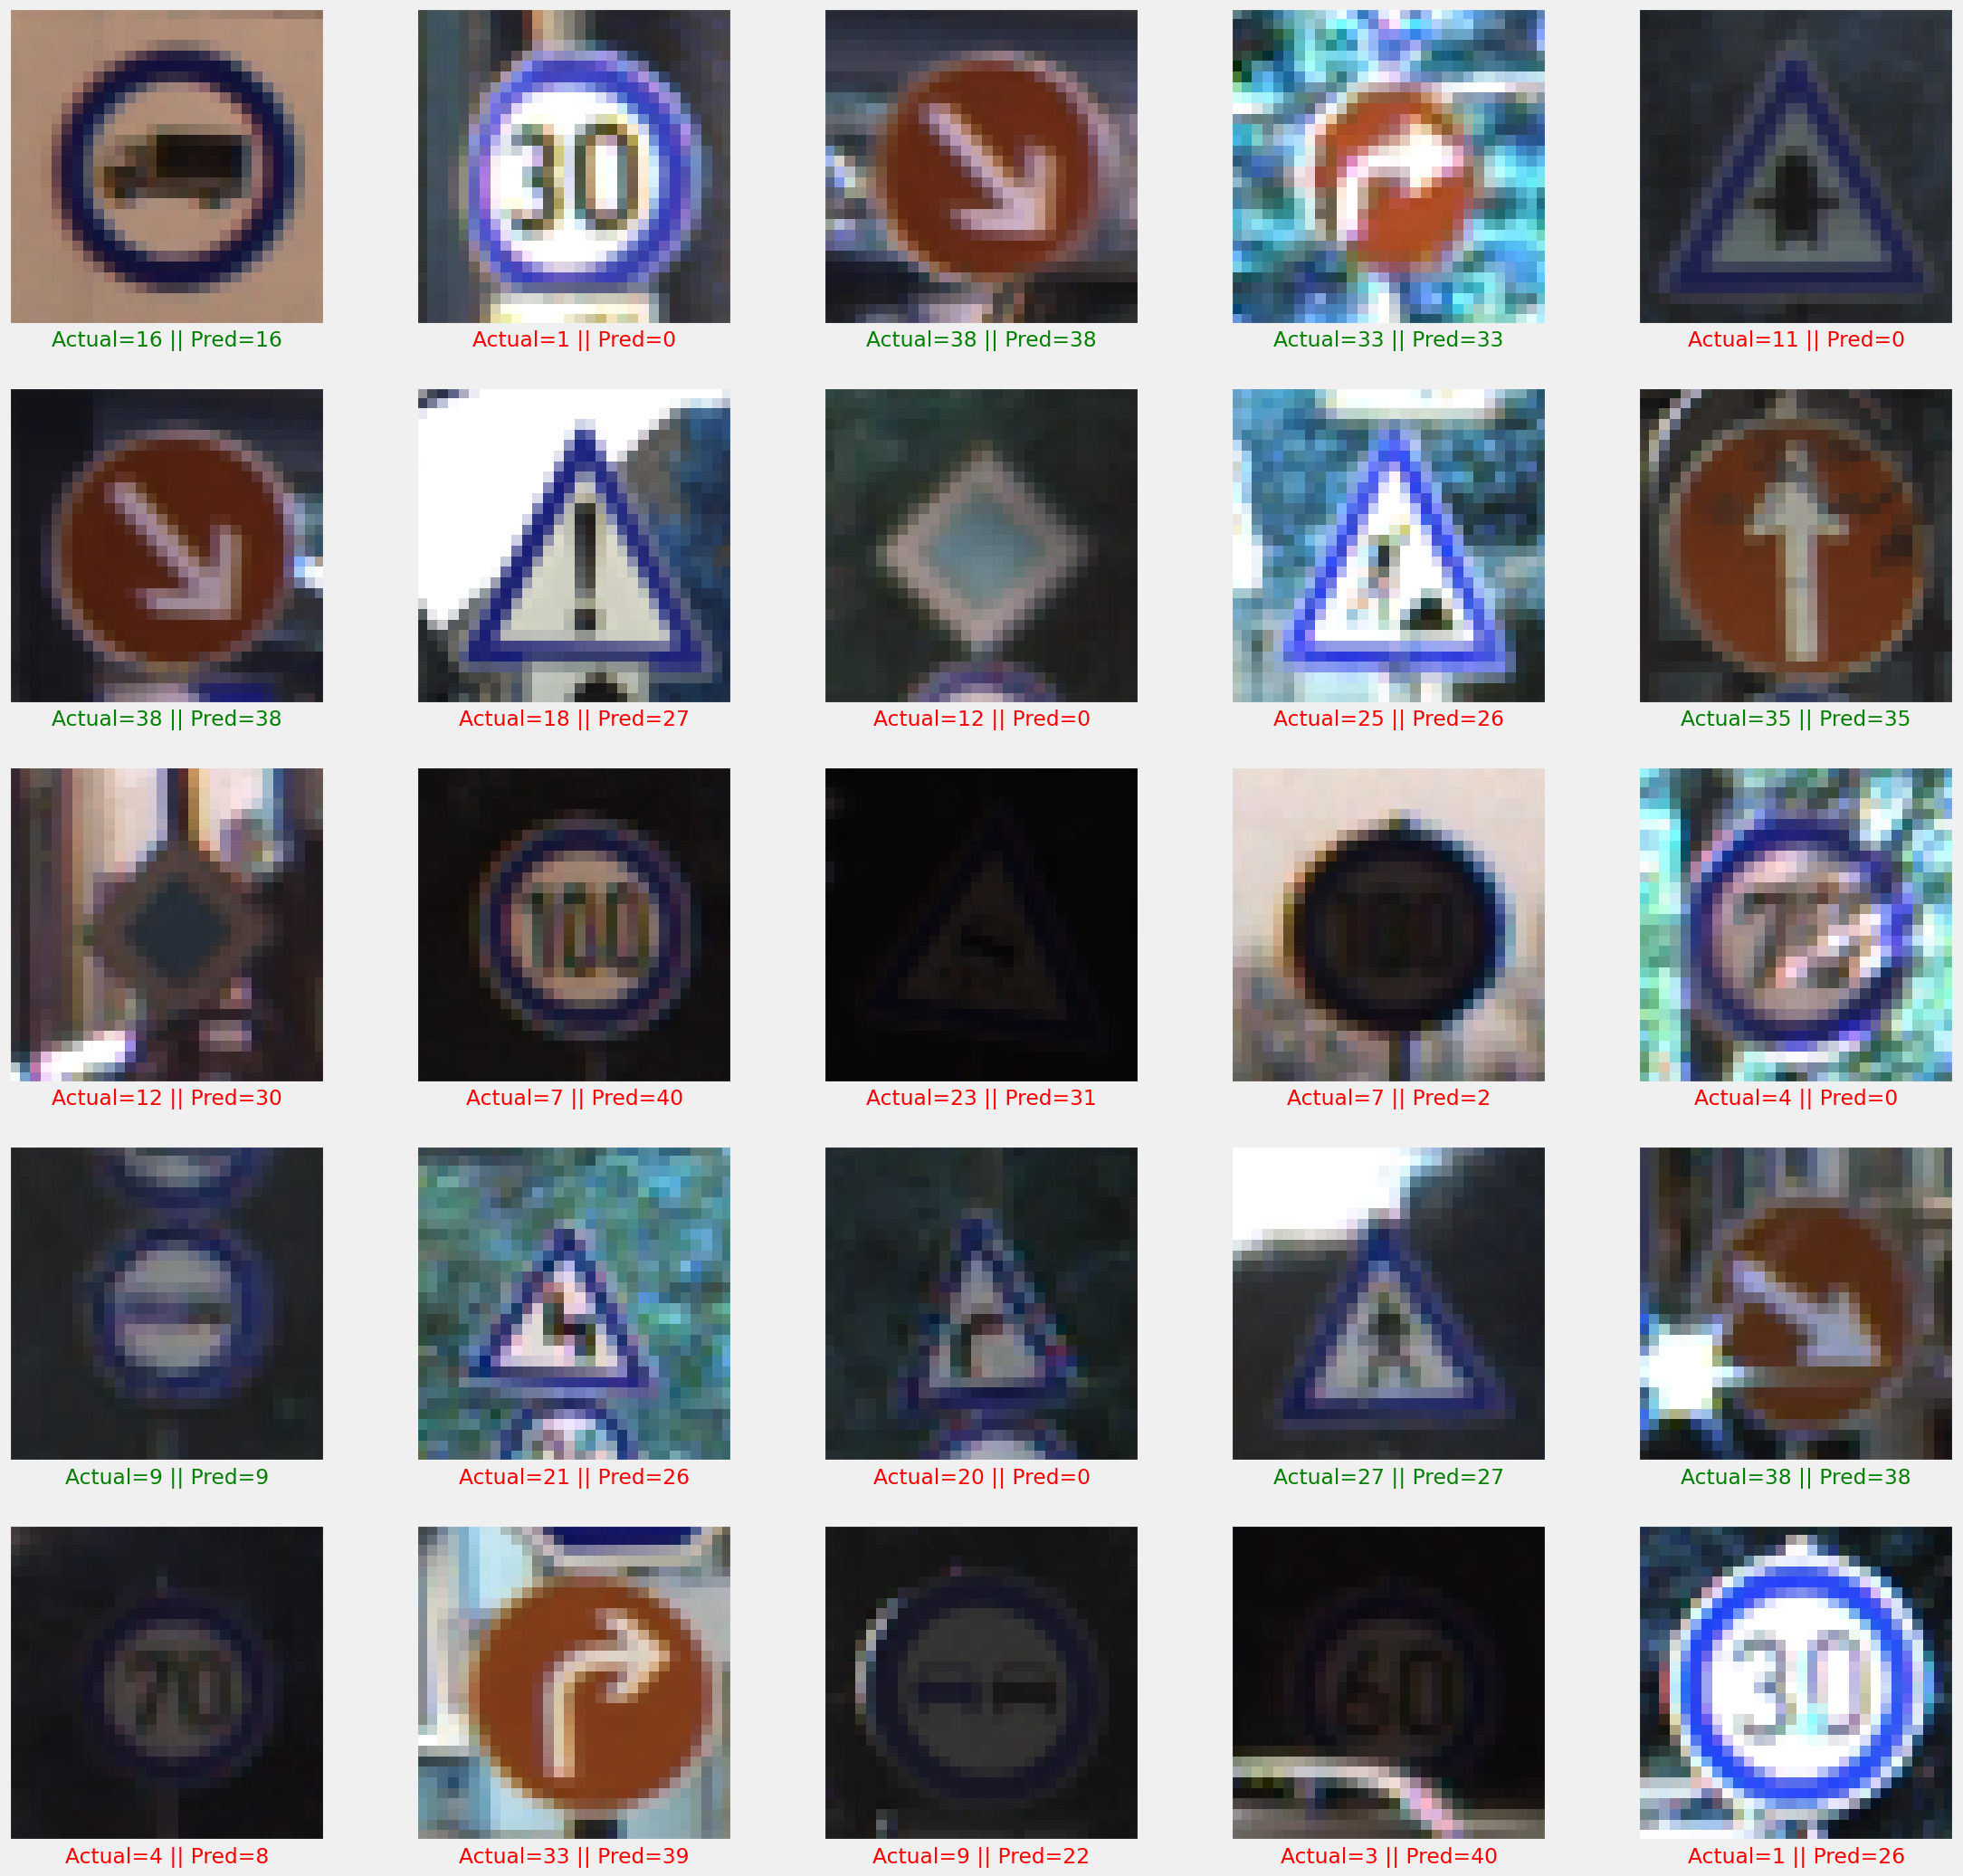

In [26]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [27]:
ls

Meta/  Meta.csv  model.h5  my_model.keras  output.weights.h5  Test/  Test.csv  Train/  Train.csv


In [28]:

model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image_path = "00000.png"
image = cv2.imread(image_path)

# image_fromarray = Image.fromarray(image, 'RGB')
# resize_image = image_fromarray.resize((30, 30))
# expand_input = np.expand_dims(resize_image,axis=0)
# input_data = np.array(expand_input)
# input_data = input_data/255

# pred = loaded_model.predict(input_data)
# result = pred.argmax()
# result
if image is None:
    print(f"Error: Could not load image from {image_path}. Check file path and format.")
else:
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((30, 30))
    expand_input = np.expand_dims(resize_image, axis=0)
    input_data = np.array(expand_input)
    input_data = input_data / 255

    pred = loaded_model.predict(input_data)
    result = pred.argmax()
    print(result)


Error: Could not load image from 00000.png. Check file path and format.
